In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def process_data(df, version='gender'):
    
    # drop columns based on gender inclusion/exclusion
    if version == 'gender':
        df.drop(columns=['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG',
                          'HFLAG', 'ASECWTH', 'PERNUM', 'CPSIDV', 'CPSIDP',
                          'ASECWT', 'NCHILD', 'NCHLT5', 'WKSWORK2', 'WKSUNEM2',
                          'WKSUNEM1', 'ADJGINC', 'TAXINC'], inplace=True)
    elif version == 'no-gender':
        df.drop(columns=['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG',
                          'HFLAG', 'ASECWTH', 'PERNUM', 'CPSIDV', 'CPSIDP',
                          'ASECWT', 'SEX', 'NCHILD', 'NCHLT5', 'WKSWORK2',
                         'WKSUNEM2','WKSUNEM1', 'ADJGINC', 
                         'TAXINC'], inplace=True)
    
    # drop rows with NaN/NIU values 
    cols_with_zeros = ['DIFFANY', 'SCHLCOLL', 'CLASSWKR', 'IND', 'OCC',
                       'LABFORCE', 'VETSTAT']
    df = df[~df[cols_with_zeros].isin([0]).any(axis=1)]
    df = df[~df['UHRSWORKT'].isin([999, 997])]
    
    # encode categorical features
    if version == 'gender':
        categorical_columns = ['RELATE', 'SEX', 'RACE', 'MARST', 'VETSTAT',
                               'FAMREL','BPL', 'CITIZEN', 'EMPSTAT', 'LABFORCE', 
                               'OCC', 'IND','CLASSWKR', 'EDUC', 'SCHLCOLL', 
                               'DIFFANY']
    elif version == 'no-gender':
        categorical_columns = ['RELATE', 'RACE', 'MARST', 'VETSTAT',
                               'FAMREL', 'BPL', 'CITIZEN', 'EMPSTAT', 'LABFORCE',
                               'OCC', 'IND','CLASSWKR', 'EDUC', 'SCHLCOLL', 
                               'DIFFANY']
    df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=None)
    
    # drop features that do not meet requirements
    columns_to_keep1 = ['OCC_2310', 'OCC_3255', 'OCC_4700', 'OCC_4720',
                       'OCC_9130', 'OCC_4760']
    columns_to_drop1 = [col for col in df_encoded.columns if col.startswith('OCC_') and col not in columns_to_keep1]
    df_encoded.drop(columns=columns_to_drop1, inplace=True)
    columns_to_keep2 = ['IND_770', 'IND_7860', 'IND_8680', 'IND_8190', 
                       'IND_7870', 'IND_7380', 'IND_9470','IND_8191']
    columns_to_drop2 = [col for col in df_encoded.columns if col.startswith('IND_') and col not in columns_to_keep2]
    df_encoded.drop(columns=columns_to_drop2, inplace=True)
    columns_to_keep3 = ['BPL_9900', 'BPL_20000', 'BPL_52100', 'BPL_51500']
    columns_to_drop3 = [col for col in df_encoded.columns if col.startswith('BPL_') and col not in columns_to_keep3]
    df_encoded.drop(columns=columns_to_drop3, inplace=True)
    columns_to_keep4 = ['RACE_100', 'RACE_200', 'RACE_651']
    columns_to_drop4 = [col for col in df_encoded.columns if col.startswith('RACE_') and col not in columns_to_keep4]
    df_encoded.drop(columns=columns_to_drop4, inplace=True)
    
    # drop NaN data
    df_encoded = df_encoded[df_encoded['UHRSWORKLY'] != 999]
    
    # outlier detection
    cols_to_check = ['AGE', 'UHRSWORKT', 'WKSWORK1', 'UHRSWORKLY', 'INCTOT']
    z_scores = stats.zscore(df_encoded[cols_to_check])
    threshold = 3
    outliers_mask = (z_scores > threshold).any(axis=1)
    df_cleaned = df_encoded[~outliers_mask]
    
    # drop perfectly correlated features
    if version == 'gender':
        df_final = df_cleaned.drop(["SEX_2", "VETSTAT_2", "EMPSTAT_12", "DIFFANY_2", "LABFORCE_2"], axis=1)
    elif version == 'no-gender':
        df_final = df_cleaned.drop(["VETSTAT_2", "EMPSTAT_12", "DIFFANY_2", "LABFORCE_2"], axis=1)
    
    # normalize ordinal features
    # UPDATE no longer normalizing INCTOT because that is our target variable
    df_final_nor = df_final.copy()
    cols_to_normalize = ['AGE', 'UHRSWORKT', 'WKSWORK1', 'UHRSWORKLY']
    scaler = MinMaxScaler()
    df_final_nor[cols_to_normalize] = scaler.fit_transform(df_final[cols_to_normalize])
    
    return df_final_nor


def split_data(df):
    
    feature_columns = df.loc[:, df.columns != 'INCTOT'].columns
    X = df[feature_columns]
    y = df['INCTOT']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    train_x = X_train.values
    train_y = y_train.values
    test_x = X_test.values
    test_y = y_test.values
    
    return train_x, test_x, train_y, test_y

In [39]:
import numpy as np

df = pd.read_csv("cps_ALL.csv")
df = df[(df["YEAR"]==2023)]
df

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,HFLAG,ASECWTH,PERNUM,CPSIDV,CPSIDP,...,SCHLCOLL,DIFFANY,WKSWORK1,WKSWORK2,UHRSWORKLY,WKSUNEM1,WKSUNEM2,INCTOT,ADJGINC,TAXINC
779822,2023,2,3,20230100363800,1,NaN,1789.60,2,202301003638021,20230100363802,...,5,1,52,6,40,99,9,42000,0,0
779823,2023,17,3,20211202723000,1,NaN,1344.38,1,202112027230011,20211202723001,...,0,2,34,3,32,0,0,22000,68500,42600
779824,2023,17,3,20211202723000,1,NaN,1344.38,2,202112027230021,20211202723002,...,0,2,52,6,40,99,9,46500,0,0
779825,2023,22,3,20211202721300,1,NaN,1182.06,1,202112027213011,20211202721301,...,5,1,52,6,60,99,9,68512,142862,102093
779826,2023,22,3,20211202721300,1,NaN,1182.06,2,202112027213021,20211202721302,...,5,1,52,6,60,99,9,80002,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851268,2023,88977,3,0,1,NaN,413.20,1,0,0,...,5,1,52,6,40,99,9,50215,90415,64515
851269,2023,88977,3,0,1,NaN,413.20,2,0,0,...,5,1,52,6,40,99,9,40200,0,0
851270,2023,88978,3,0,1,NaN,416.37,1,0,0,...,0,1,52,6,40,99,9,33113,111205,85305
851271,2023,88978,3,0,1,NaN,416.37,2,0,0,...,0,1,52,6,40,99,9,78092,0,0


In [3]:
df_f = process_data(df, version='gender')
df_f_nosex = df_f.copy()
df_f_nosex.drop("SEX_1", axis=1, inplace=True)
df_f_nosex

,AGE,UHRSWORKT,WKSWORK1,UHRSWORKLY,INCTOT,RELATE_101,RELATE_202,RELATE_203,RELATE_301,RELATE_501,...,EDUC_111,EDUC_123,EDUC_124,EDUC_125,SCHLCOLL_1,SCHLCOLL_2,SCHLCOLL_3,SCHLCOLL_4,SCHLCOLL_5,DIFFANY_1
779822,0.918919,0.557143,1.000000,0.573529,42000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
779825,0.540541,0.414286,1.000000,0.867647,68512,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
779826,0.594595,0.842857,1.000000,0.867647,80002,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
779829,0.081081,0.557143,0.294118,0.279412,8000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
779835,0.648649,0.557143,1.000000,0.573529,205145,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851266,0.648649,0.557143,1.000000,0.573529,40500,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
851267,0.675676,0.557143,1.000000,0.573529,60750,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
851268,0.918919,0.557143,1.000000,0.573529,50215,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
851269,0.918919,0.557143,1.000000,0.573529,40200,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [4]:
import hdbscan
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

min_cluster_sizes = range(5, 21, 5)
min_samples_list = range(3, 12, 3)

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        hdbscan_clust = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan_clust.fit_predict(df_f_nosex)

        mask = labels != -1
        if np.sum(mask) > 0:
            silhouette_avg = silhouette_score(df_f_nosex[mask], labels[mask])
            unique_clusters = np.unique(labels)
            num_clusters = len(unique_clusters[unique_clusters != -1])
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'silhouette_score': silhouette_avg,
                'num_clusters': num_clusters
            })
        else:
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'silhouette_score': None,
                'num_clusters': 0
            })

results_df = pd.DataFrame(results)

best_config = results_df.loc[results_df['silhouette_score'].idxmax()]
print(best_config)

min_cluster_size     15.00000
min_samples           9.00000
silhouette_score      0.78639
num_clusters        670.00000
Name: 8, dtype: float64


In [40]:
sizes = pd.Series(labels[mask]).value_counts()
top_five = sizes.head(6).index.tolist()

df_1 = df_f_nosex[labels == top_five[0]]
df_2 = df_f_nosex[labels == top_five[1]]
df_3 = df_f_nosex[labels == top_five[2]]
df_4 = df_f_nosex[labels == top_five[3]]
df_5 = df_f_nosex[labels == top_five[4]]
df_6 = df_f_nosex[labels == top_five[5]]

In [10]:
import matplotlib.pyplot as plt
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
def plot_occupation_distributions(dfs, titles, columns_of_interest):
    dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
    axes = axes.flatten()

    colors = ['ORANGE', '#98FB98', '#FFECB3', '#ADD8E6','#E6E6FA', '#FFDAB9']

    for df, ax, title in zip(dfs, axes, titles):
        ones = [(column, df[column].sum()) for column in columns_of_interest]
        sorted_counts = sorted(ones, key=lambda x: x[1], reverse=True)
        sorted_columns, sorted_values = zip(*sorted_counts)

        ax.pie(sorted_values, labels=sorted_columns, autopct='%1.1f%%', startangle=10, colors=colors)
        ax.axis('equal')
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

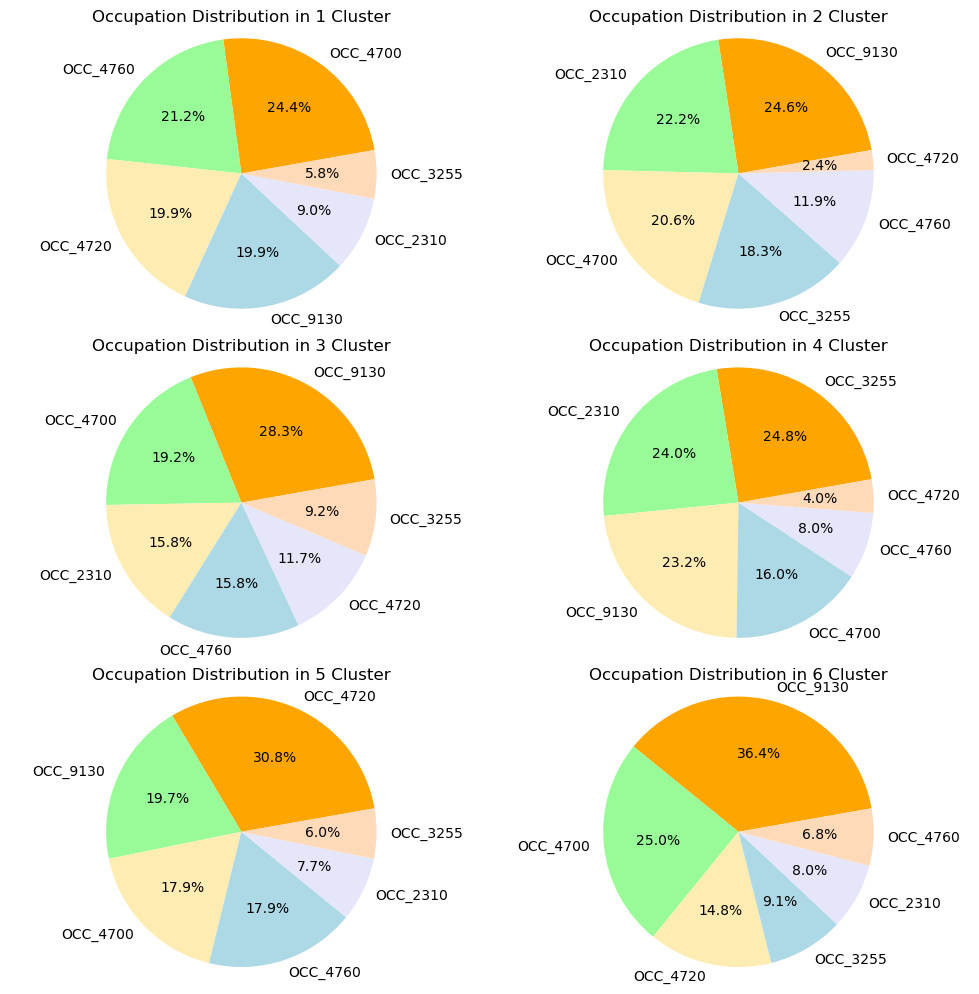

In [37]:
titles = ['Occupation Distribution in 1 Cluster', 'Occupation Distribution in 2 Cluster', 
          'Occupation Distribution in 3 Cluster', 'Occupation Distribution in 4 Cluster', 
          'Occupation Distribution in 5 Cluster', 'Occupation Distribution in 6 Cluster']
columns_of_interest = ['OCC_2310', 'OCC_3255', 'OCC_4700', 'OCC_4720', 'OCC_9130', 'OCC_4760']
plot_occupation_distributions(dfs, titles, columns_of_interest)

In [17]:
import pandas as pd
occ_columns = ['OCC_4700', 'OCC_9130', 'OCC_3255', 'OCC_4720', 'OCC_9130']

df_1_occ = df_1[(df_1['OCC_4700'] == 1)]
df_2_occ = df_2[(df_2['OCC_9130'] == 1)]
df_3_occ = df_3[(df_3['OCC_9130'] == 1)]
df_4_occ = df_4[(df_4['OCC_3255'] == 1)]
df_5_occ = df_5[(df_5['OCC_4720'] == 1)]
df_6_occ = df_6[(df_6['OCC_9130'] == 1)]

df_1_all = pd.merge(df_1_occ, df_f)
df_2_all = pd.merge(df_2_occ, df_f)
df_3_all = pd.merge(df_3_occ, df_f)
df_4_all = pd.merge(df_4_occ, df_f)
df_5_all = pd.merge(df_5_occ, df_f)
df_6_all = pd.merge(df_6_occ, df_f)

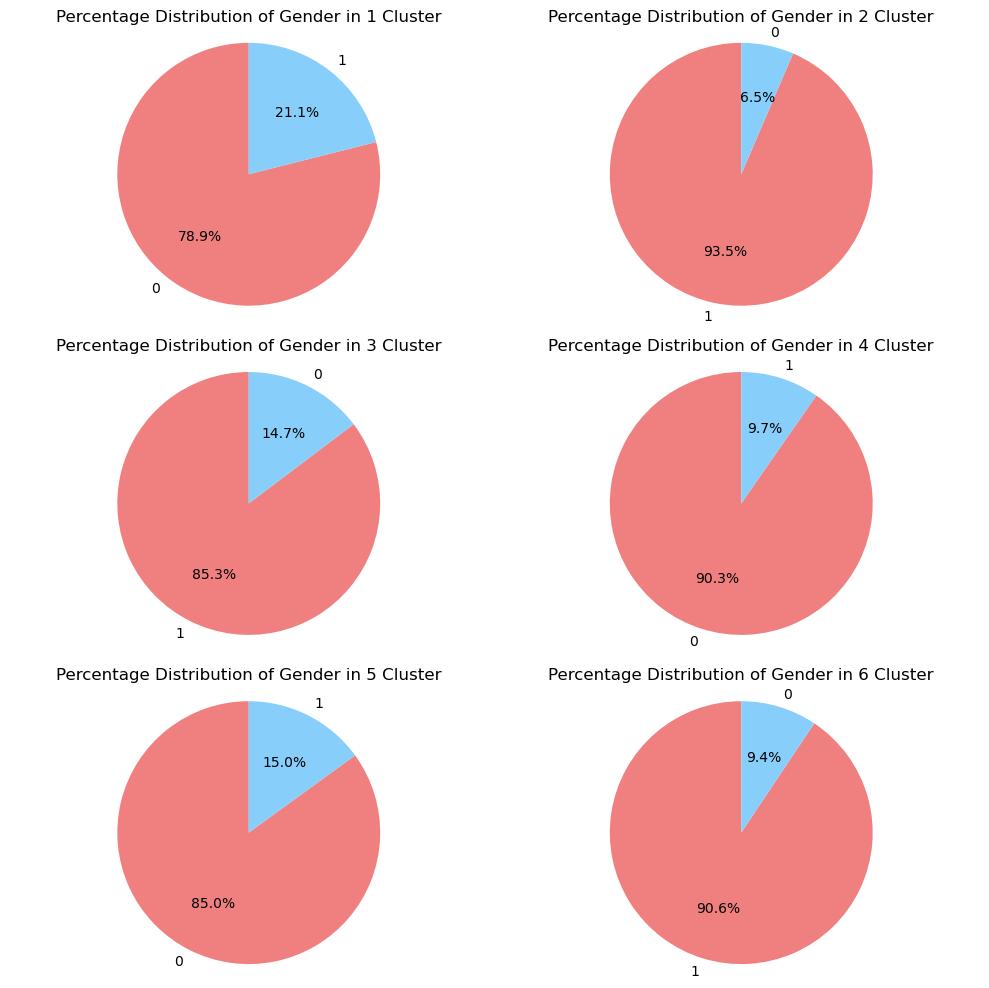

In [36]:
import matplotlib.pyplot as plt

colors = ['lightcoral', 'lightskyblue']
df_i_all = [df_1_all, df_2_all, df_3_all, df_4_all, df_5_all, df_6_all]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i, df in enumerate(df_i_all):
    value_counts = df['SEX_1'].value_counts(normalize=True)
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].axis('equal') 
    axes[i].set_title(f'Percentage Distribution of Gender in {i+1} Cluster')

if len(df_i_all) < len(axes):
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [42]:
results = []

for i in range(1, 7):
    df = eval(f'df_{i}_all')
    mean_sex_1 = df[df['SEX_1'] == 1]['INCTOT'].mean()
    mean_sex_0 = df[df['SEX_1'] == 0]['INCTOT'].mean()
    results.append((f'df_{i}_all', mean_sex_1, mean_sex_0))

for result in results:
    print(f"{result[0]}:Avrange Income for Male: {result[1]}, Avrange Income for Female: {result[2]}")

df_1_all:Avrange Income for Male: 30000.75, Avrange Income for Female: 30002.066666666666
df_2_all:Avrange Income for Male: 50007.0, Avrange Income for Female: 50000.0
df_3_all:Avrange Income for Male: 40003.620689655174, Avrange Income for Female: 40006.4
df_4_all:Avrange Income for Male: 60005.0, Avrange Income for Female: 60008.75
df_5_all:Avrange Income for Male: 20003.166666666668, Avrange Income for Female: 20000.558823529413
df_6_all:Avrange Income for Male: 35001.10344827586, Avrange Income for Female: 35006.0


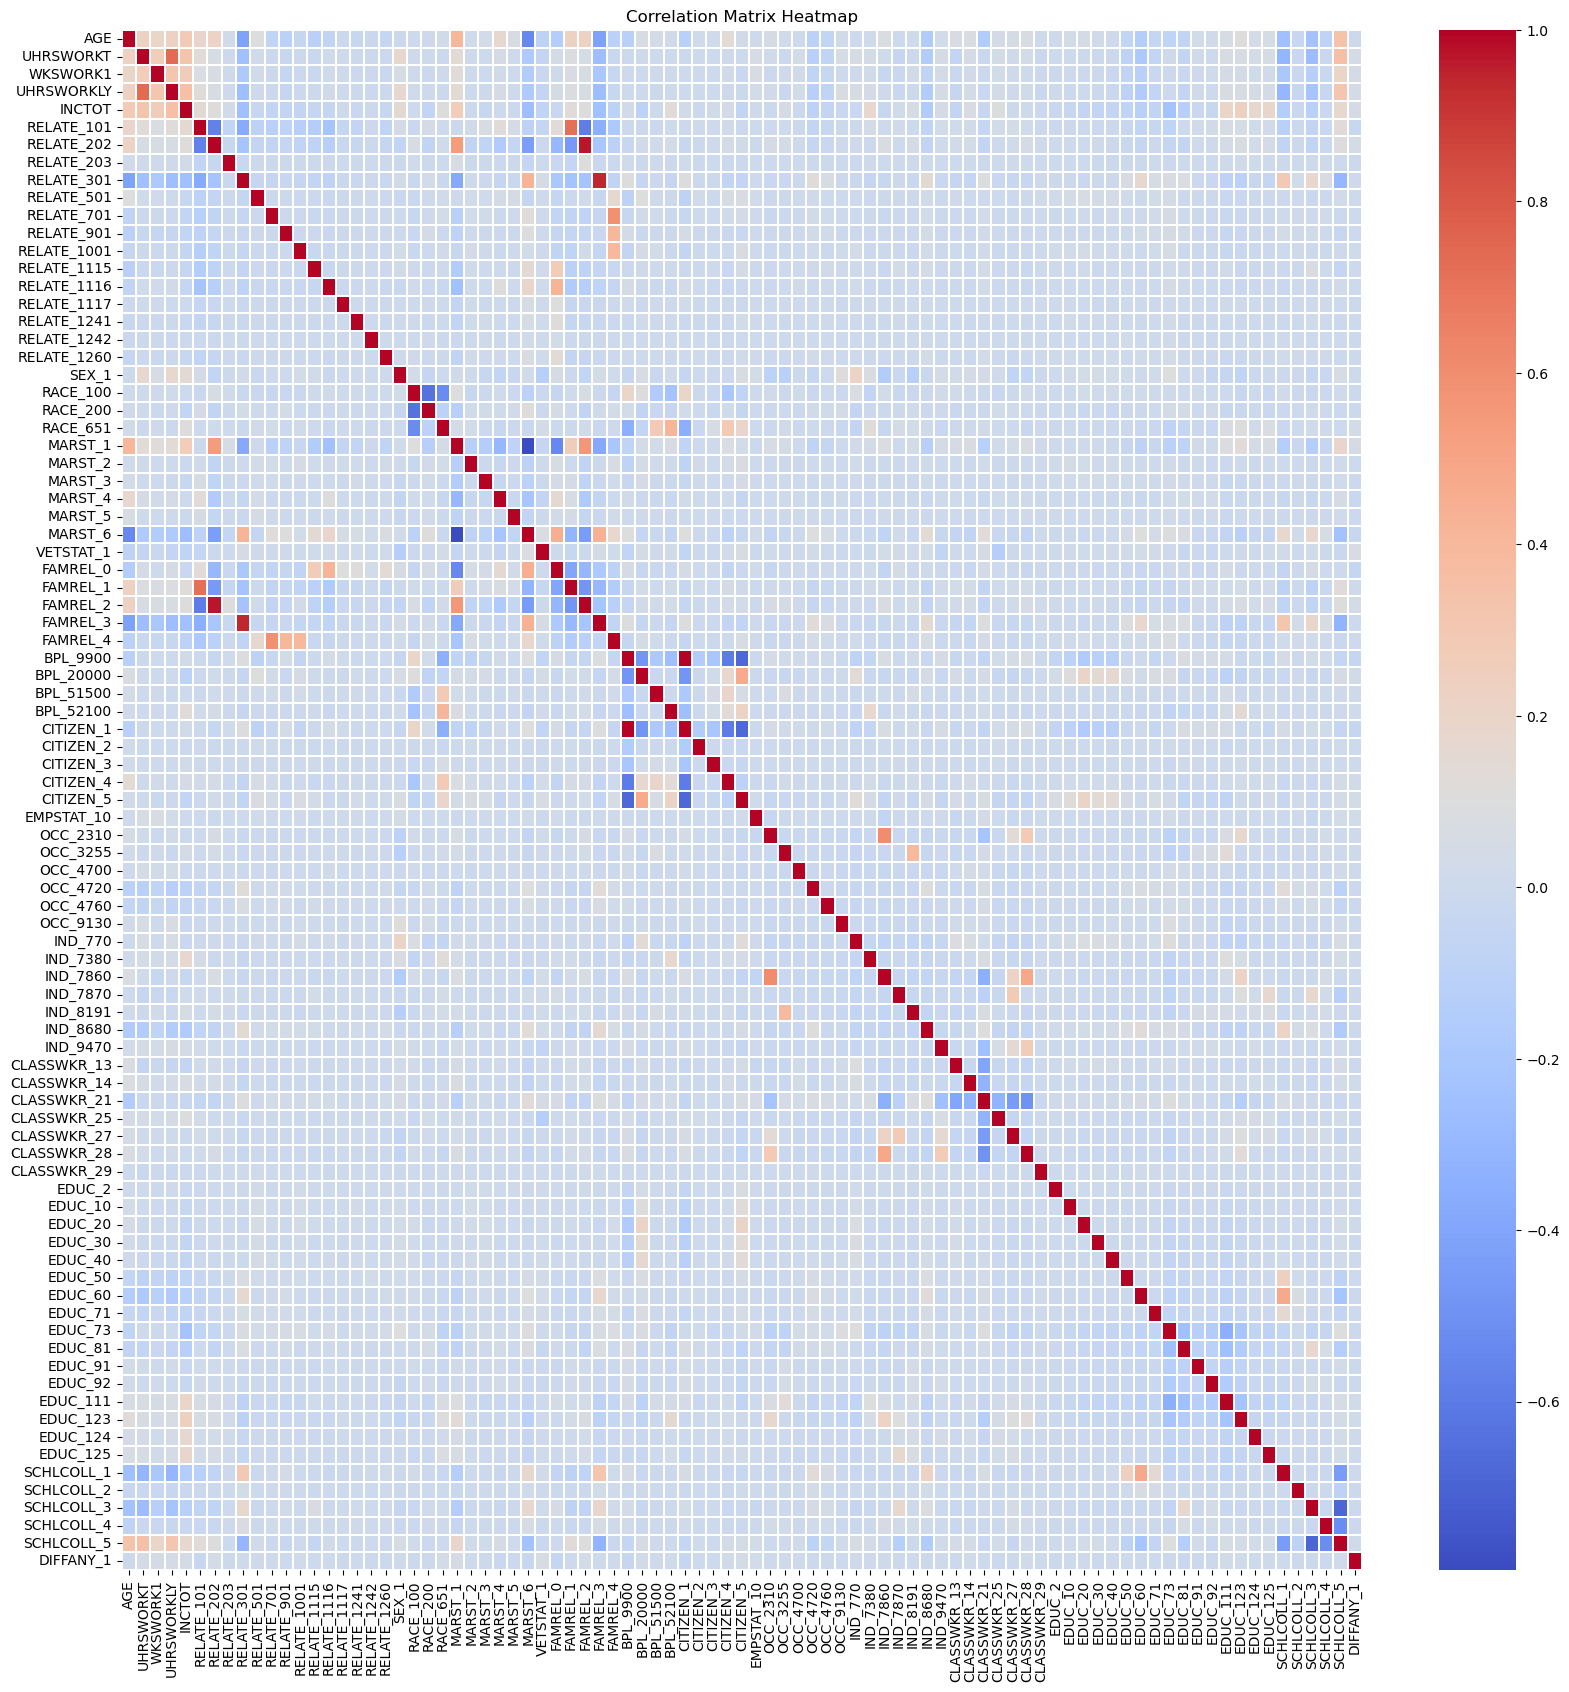

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df_f.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.1)
plt.title('Correlation Matrix Heatmap')
plt.show()